# Hotel Rating Prediction  

Given *TripAdvisor hotel reviews*, let's try to predict the **rating** associated with a given review.

We will use a TensorFlow RNN to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd

import re
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


# Processing Text

In [5]:
stop_words = stopwords.words('english')

In [6]:
def process_text(text):
    text = re.sub(r'\d+', ' ', text)
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text

In [7]:
reviews = data['Review'].apply(process_text)

In [8]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

sequences = tokenizer.texts_to_sequences(reviews)

In [9]:
max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

print("Max sequence length:", max_seq_length)

Max sequence length: 1833


In [11]:
inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
inputs

array([[   8,    1,  174, ...,    0,    0,    0],
       [ 139,  136,  262, ...,    0,    0,    0],
       [   8,    9,   76, ...,    0,    0,    0],
       ...,
       [ 139,  733,    8, ...,    0,    0,    0],
       [   1, 3785, 2479, ...,    0,    0,    0],
       [  27, 1156,  187, ...,    0,    0,    0]], dtype=int32)

# Encoding Labels

In [12]:
data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [14]:
labels = np.array(data['Rating'].apply(lambda x: 1 if x == 5 else 0))
labels

array([0, 0, 0, ..., 0, 0, 0])

# Splitting

In [15]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=0.7, random_state=100)

# Modeling/Training

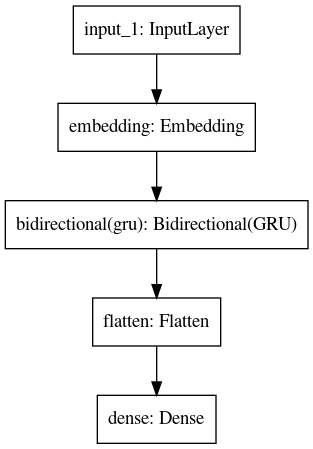

In [16]:
embedding_dim = 128

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True)
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model)

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_inputs,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
359/359 [==============================] - 64s 177ms/step - loss: 0.5187 - accuracy: 0.7481 - auc: 0.8237 - val_loss: 0.4282 - val_accuracy: 0.8013 - val_auc: 0.8832
Epoch 2/20
359/359 [==============================] - 63s 176ms/step - loss: 0.2750 - accuracy: 0.8883 - auc: 0.9535 - val_loss: 0.4926 - val_accuracy: 0.7769 - val_auc: 0.8637
Epoch 3/20
359/359 [==============================] - 64s 177ms/step - loss: 0.0898 - accuracy: 0.9678 - auc: 0.9950 - val_loss: 0.7139 - val_accuracy: 0.7588 - val_auc: 0.8434


# Results

In [18]:
model.evaluate(test_inputs, test_labels)

193/193 [==============================] - 12s 64ms/step - loss: 0.4347 - accuracy: 0.7962 - auc: 0.8787


[0.43469882011413574, 0.7961938977241516, 0.8787051439285278]